# Python Code from Neuron to Neural Network

This is a continuation of the post called [Python Code from Derivatives to Backpropagation](https://shahaliyev.org/writings/backprop). Based on [Andrej Karpathy's lecture](https://www.youtube.com/watch?v=VMj-3S1tku0).

Table of Contents:

- Activation Functions
- 2-dimensional Neuron
- N-dimensional Neuron
- Artificial Neural Network
- Iris Dataset
- Training a Custom MLP Classifier

In [1]:
# This is a graph visualization code from micrograd, no need to understand the details
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.3f | grad %.3f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Recall: Backpropagation

In [2]:
# This is the code from previous lecture
# It is important to understand _backward function
class Value:
  def __init__(self, data, _prev=(), _op='', label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self._backward = lambda: None
    self.grad = 0.0

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other),'+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other),'*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (Value(-1) * other) # self + (-other)

  def __repr__(self):
    return f'{self.label}: {self.data}'

In [3]:
a = Value(5, label='a')
b = Value(3, label='b')
c = a + b;   c.label = 'c'
d = Value(10, label='d')
L = c * d;   L.label = 'L'

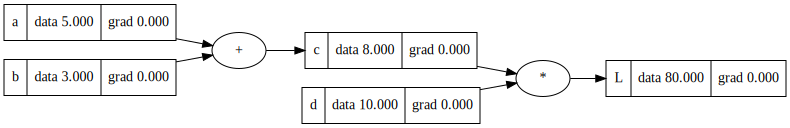

In [4]:
draw_dot(L)

In [5]:
epochs = 10
learning_rate = 0.01

for _ in range(epochs):
  L.grad = 1.0

  # backward pass
  L._backward()
  c._backward()

  # optimization (gradient descent)
  a.data -= learning_rate * a.grad
  b.data -= learning_rate * b.grad
  d.data -= learning_rate * d.grad

  # forward pass
  c = a + b
  L = c * d

  print(f'Loss: {L.data:.2f}')

Loss: 77.38
Loss: 74.81
Loss: 72.31
Loss: 69.87
Loss: 67.49
Loss: 65.16
Loss: 62.88
Loss: 60.66
Loss: 58.48
Loss: 56.35


In [6]:
# Equivalent implementation in PyTorch
# pay attention to requires_grad, no_grad() and zero_()

import torch

a = torch.tensor(5.0, requires_grad = True);
b = torch.tensor(3.0, requires_grad = True);
c = a + b
d = torch.tensor(10.0,requires_grad = True);
L = c * d

for _ in range(epochs):
  # backward pass
  L.backward()

  # optimization (gradient descent)
  with torch.no_grad():
    a -= learning_rate * a.grad
    b -= learning_rate * b.grad
    d -= learning_rate * d.grad

  # avoids accumulating gradients
  # comment this out to see how it affects the learning
  a.grad.zero_()
  b.grad.zero_()
  d.grad.zero_()

  # forward pass
  c = a + b
  L = c * d

  print(f'Loss: {L.data:.2f}')

Loss: 77.38
Loss: 74.81
Loss: 72.31
Loss: 69.87
Loss: 67.49
Loss: 65.16
Loss: 62.88
Loss: 60.66
Loss: 58.48
Loss: 56.35


## Activation Function

The function `f(x) = x * w` is a linear function always passing from origin. The real world data, however, will be much more complex, and in order to describe a pattern in the data our Machine Learning model should return a more flexible function. For that, we will do two things: add bias `b` and bring non-linearity with an _activation function_. We can choose different non-linear activation functions with the condition that it should be differentiable (otherwise we won't be able to calculate gradients for backpropagation). We will implement `sigmoid`(logistic) activation function which has the following formula:

![sigmoid](https://wikimedia.org/api/rest_v1/media/math/render/svg/b4bfdf0c74ed6e975d44f8a4124c2ffcd13b2df7)

Sigmoid function not only makes a linear function non-linear and continuous, but also maps any value of `x` to be between 0 and 1. It may be useful when we want to predict probabilities for different output classes.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def sigmoid(x):
  return 1.0 / (1 + np.exp(-x)) # see formula above

In [9]:
# a simple linear function where activation will be applied
def f(x, w=0.5, b=10, activation=None):
  out = x * w + b
  return activation(out) if activation else out

In [10]:
def plot(f, x, activation=None):
  plt.figure(figsize=(4, 4))
  x_all = np.linspace(-50, 50, 100)
  y_all = f(x_all, activation=activation)
  plt.plot(x_all, y_all)
  plt.scatter(x, f(x, activation=activation), color='r')
  plt.show()

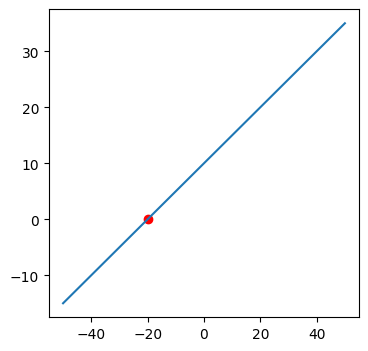

In [11]:
x = -20
plot(f, x)

Now we will plot the exact same point mapped into the non-linear function between `0` and `1`. Try out different `x` values and see the plots.

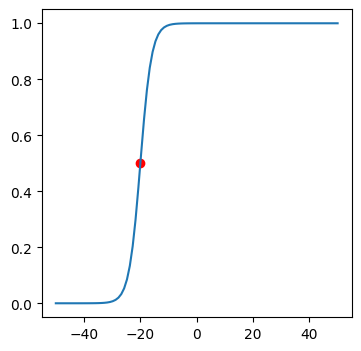

In [12]:
plot(f, x, sigmoid)

**Exercise:** Implement other [activation functions](https://en.wikipedia.org/wiki/Activation_function) (e.g. `tanh`, `relu`) and see the plot.

**Exercise:** What could be the distadvantage of using sigmoid activation function?

## Artificial Neuron

Funcs - Own work ([CC0](https://creativecommons.org/publicdomain/zero/1.0/deed.en) | [Wikimedia Commons](https://commons.wikimedia.org/w/index.php?curid=148910507))

![Artificial Neuron](https://upload.wikimedia.org/wikipedia/commons/c/c6/Artificial_neuron_structure.svg)

An artificial neuron is simply a linear function passing through an activation function  (e.g. `sigmoid(x * w + b)`). The illustration above describes an N-dimensional neuron, accepting inputs between <code>x<sub>1</sub> ... x<sub>n</sub></code>. The function `f` we had above is a very simple neuron with 1-dimensional input.

**Question:** What could be input values for predicting the probability of a customer cancelling their subscription?

Before creating our neuron, we will first make some updates to the `Value` class.

Not only value class should have a `sigmoid(x)` function, but also it should be able to calculate a derivative for it.

**Exercise:** Find the derivative of the `sigmoid` function:

![sigmoid](https://wikimedia.org/api/rest_v1/media/math/render/svg/b4bfdf0c74ed6e975d44f8a4124c2ffcd13b2df7)

The `requires_grad` flag (similar to PyTorch) will tell which _parameters_ are trainable and requires gradient calculation and update (Note that this feature is not implemented in `micrograd`).

For example, it doesn't make sense to modify the real-life training inputs `x1` and `x2` for our neuron. We shouldn't spend resources for calculating unnecessary gradients. Our goal is to nudge only the weight and bias (i.e. parameter) values, as well as the nodes dependent on them, in order to minimize the eventual loss.

In [13]:
class Value:
  def __init__(self, data, _prev=(), _op='', requires_grad=False, label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self._backward = lambda: None
    self.grad = 0.0
    self.requires_grad = requires_grad

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other), '+', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad = 1.0 * out.grad
      if other.requires_grad:
        other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other), '*', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad = other.data * out.grad
      if other.requires_grad:
        other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (Value(-1) * other) # self + (-other)

  def sigmoid(self):
    s = 1.0 / (1 + np.exp(-self.data))
    out = Value(s, (self, ), 'sigmoid', self.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad = s * (1.0 - s) * out.grad
    out._backward = _backward

    return out

  def __repr__(self):
    return f'Value({self.data:.4f})'

We will initially implement a simple `Neuron` class in 3D (2-dimensional input values and an output value). The function will have two inputs `x1` and `x2`, which will become `Value` objects. Their weights `w1` and `w2` will determine how much input (e.g. age of a customer) influences outcome.

In [14]:
from mpl_toolkits.mplot3d import Axes3D

class Neuron:
  def __init__(self):
    self.w1 = Value(np.random.uniform(-1, 1), label='w1', requires_grad=True)
    self.w2 = Value(np.random.uniform(-1, 1), label='w2', requires_grad=True)
    self.b = Value(0, label='b', requires_grad=True)

  def __call__(self, x1, x2):
    out = x1 * self.w1 + x2 * self.w2 + self.b
    return out.sigmoid()

  # this code here is for plotting, no need to understand, works for only 3D
  def plot(self):
    x1_vals = np.linspace(-5, 5, 100)
    x2_vals = np.linspace(-5, 5, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    Z = np.zeros_like(X1)

    for i in range(X1.shape[0]):
      for j in range(X1.shape[1]):
        x1 = Value(X1[i, j])
        x2 = Value(X2[i, j])
        output = self(x1, x2)
        Z[i, j] = output.data

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_title(f'Neuron Output with Sigmoid Activation)')
    plt.show()

Now we can initialize our inputs and neuron to see our computation graph. Our loss will be simple: the ground truth label `y` minus the predicted probability. Let's assume that, our input values `x1` and `x2` correspond to a customer who made the purchase (`y = 1`). We will try out both activation functions and see their plots.

In [15]:
x1 = Value(2, label='x1')
x2 = Value(3, label='x2')
y  = Value(1, label= 'y')

n = Neuron()

pred = n(x1, x2);      pred.label = 'pred'
L = y - pred;          L.label = 'loss'

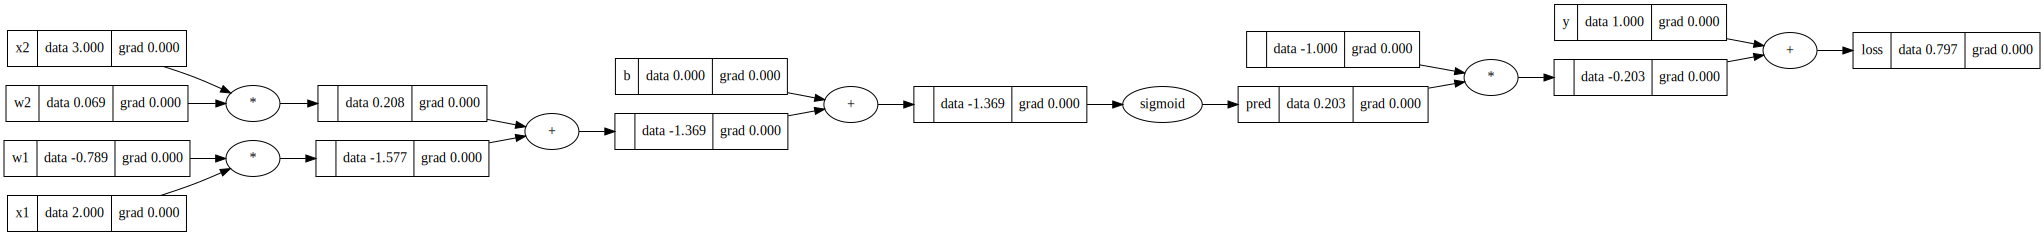

In [16]:
draw_dot(L)

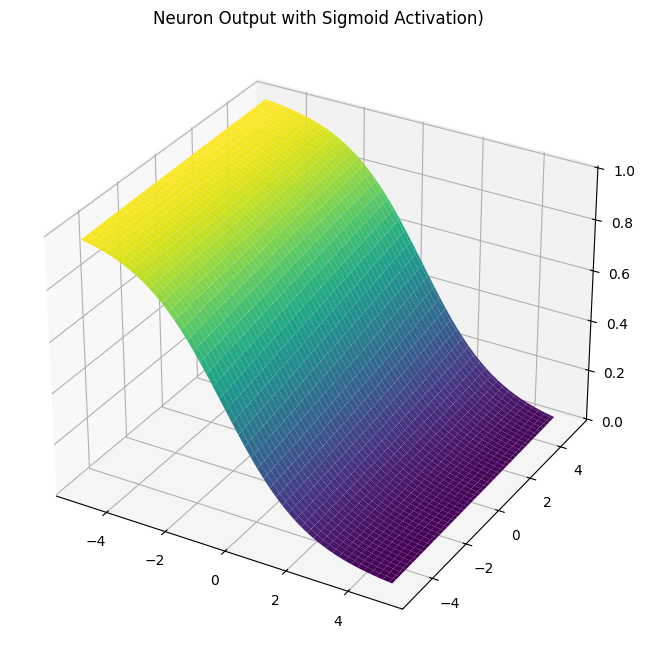

In [17]:
n.plot()

The ground truth label `1` tells us that we should push our probability towards `1.0`. In other words, as our loss `L` here is a simple error value corresponding to `1 - prob`, we should try to minimize the loss down to zero with backpropagation. However, our computation graph is bigger than how it was before. The `_backward` pass function we call manually on each node is not scalable. Ideally, we should have a single function `backward()` to calculate all the gradients, which we previously saw in the PyTorch implementation. For that, we will need to sort the nodes of the computation graph (in this case, from input/weight nodes until the probability node). We can achieve that with a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting) function implemented for [micrograd](https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py).

In [18]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(pred)
topo

[Value(2.0000),
 Value(-0.7886),
 Value(-1.5772),
 Value(3.0000),
 Value(0.0694),
 Value(0.2081),
 Value(-1.3691),
 Value(0.0000),
 Value(-1.3691),
 Value(0.2028)]

We will integrate topological sort into our `Value` object and implement complete backward pass. We can also add a simple gradient descent function `optimize()` which will use this topology. Finally, instead of overriding gradients (`=`), we will accumulate them (`+=`) to avoid gradient update bugs when using the same node more than once in an operation. And as a consequence, we will have to reset gradients with `zero_()` (similar to PyTorch) so that the gradients of different backward passes will not affect each other (it does the exact same thing as `self.grad = 0.0` was doing before gradient accumulation). Although, to be precise, `zero_()` function should reset only the gradient of `self`, and it is actually a function called `zero_grad()` of `optimizer` in PyTorch which resets gradients accross all nodes.

In [ ]:
class Value:
  def __init__(self, data, _prev=(), _op='', requires_grad=False, label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self._backward = lambda: None
    self.grad = 0.0
    self.requires_grad = requires_grad
    self.topo = self.build_topo()
    self.params = [node for node in self.topo if node.requires_grad]

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other), '+', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += 1.0 * out.grad
      if other.requires_grad:
        other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other), '*', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += other.data * out.grad
      if other.requires_grad:
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (Value(-1) * other) # self + (-other)

  def sigmoid(self):
    s = 1.0 / (1 + np.exp(-self.data))
    out = Value(s, (self, ), 'sigmoid', self.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += s * (1.0 - s) * out.grad
    out._backward = _backward

    return out

  def build_topo(self):
    # topological order all of the children in the graph
    topo = []
    visited = set()

    def _build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          _build_topo(child)
        topo.append(node)
    _build_topo(self)

    return topo

  def backward(self):
    if self.requires_grad:
      self.grad = 1.0
      for node in reversed(self.params):
        node._backward()

  def optimize(self, learning_rate=0.01):
    for node in self.params:
      node.data -= learning_rate * node.grad

  def zero_(self):
    self.grad = 0.0

  def zero_grad(self):
    for node in self.params:
      node.grad = 0.0

  def __repr__(self):
    return f'Value({self.data})'

In addition to the `_backward()` function which calculated the derivatives for only immediate previous nodes, we now have the `backward()` function which calculates derivates for all the nodes (we also won't forget to set the gradient to `1.0` in the beginning). Once we plot the graph, pay attention that the input and leaf node gradients which we have no control over are not calculated, thanks to `requires_grad`.

In [20]:
x1 = Value(2, label='x1')
x2 = Value(5, label='x2')
y  = Value(1, label= 'y')

n = Neuron()

pred = n(x1, x2);      pred.label = 'pred'
L = y - pred;          L.label = 'loss'

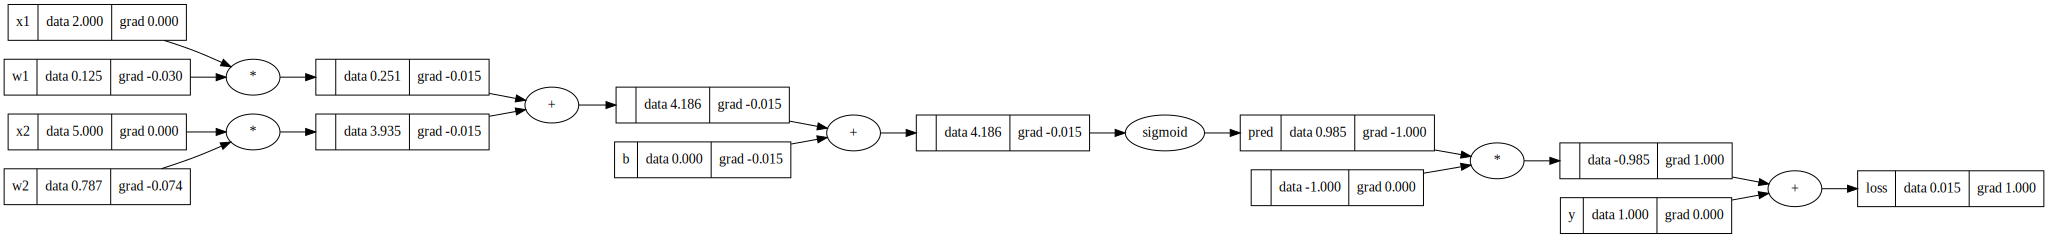

In [21]:
L.backward()
draw_dot(L)

We can finally implement complete backpropogatation with the goal of increasing the final probability to `1.0` (decreasing the loss down to zero).

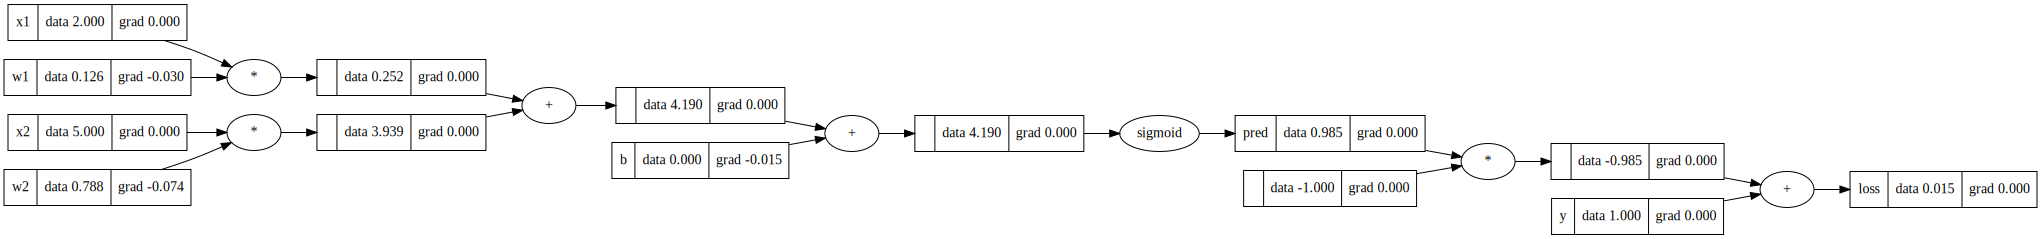

In [22]:
# gradient descent
L.optimize()

# forward pass
pred = n(x1, x2);      pred.label = 'pred'
L = y - pred;          L.label = 'loss'

draw_dot(L)

Let's repeat the backpropagation in multiple epochs until we achieve a minimal loss. We will also print the parameters to see when our neuron function returns a maximum probability for the given input values. And we will make sure to not forget to reset the gradients.

In [ ]:
while True:
  L.zero_grad()

  # backward pass
  L.backward()

  # gradient descent
  L.optimize()

  # forward pass
  pred = n(x1, x2);
  L = y - pred;

  print(f'Loss {L.data:.4f}')

  if L.data < 0.01:
    print(f'\nInputs: {x1} {x2}')
    print(f'Parameters: {n.w1} {n.w2} {n.b}')
    print(f'Prediction Probability: {pred.data}')
    break

Loss 0.0148
Loss 0.0148
Loss 0.0147
Loss 0.0147
Loss 0.0146
Loss 0.0145
Loss 0.0145
Loss 0.0144
Loss 0.0144
Loss 0.0143
Loss 0.0142
Loss 0.0142
Loss 0.0141
Loss 0.0141
Loss 0.0140
Loss 0.0139
Loss 0.0139
Loss 0.0138
Loss 0.0138
Loss 0.0137
Loss 0.0137
Loss 0.0136
Loss 0.0136
Loss 0.0135
Loss 0.0134
Loss 0.0134
Loss 0.0133
Loss 0.0133
Loss 0.0132
Loss 0.0132
Loss 0.0131
Loss 0.0131
Loss 0.0130
Loss 0.0130
Loss 0.0129
Loss 0.0129
Loss 0.0128
Loss 0.0128
Loss 0.0127
Loss 0.0127
Loss 0.0127
Loss 0.0126
Loss 0.0126
Loss 0.0125
Loss 0.0125
Loss 0.0124
Loss 0.0124
Loss 0.0123
Loss 0.0123
Loss 0.0122
Loss 0.0122
Loss 0.0122
Loss 0.0121
Loss 0.0121
Loss 0.0120
Loss 0.0120
Loss 0.0119
Loss 0.0119
Loss 0.0119
Loss 0.0118
Loss 0.0118
Loss 0.0117
Loss 0.0117
Loss 0.0117
Loss 0.0116
Loss 0.0116
Loss 0.0115
Loss 0.0115
Loss 0.0115
Loss 0.0114
Loss 0.0114
Loss 0.0113
Loss 0.0113
Loss 0.0113
Loss 0.0112
Loss 0.0112
Loss 0.0112
Loss 0.0111
Loss 0.0111
Loss 0.0111
Loss 0.0110
Loss 0.0110
Loss 0.0109
Loss

## N-dimensional Neuron

We have just now trained our 2-dimensional input neuron to find suitable parameter values for achieving a maximum probability for input values `x1` and `x2`. Now we would like to create N-dimensional neuron which will accept much more inputs, similar to what we saw in the illustration of artificial neuron: <code>x<sub>1</sub> ... x<sub>n</sub></code>. As a consequence, our neuron will have to learn the parameter values for N-dimensional weights <code>w<sub>1</sub> ... w<sub>n</sub></code>.

In [24]:
class Neuron:
  def __init__(self, N):
    self.W = [Value(np.random.uniform(-1, 1), label=f'w{i}', requires_grad=True) for i in range(N)]
    self.b = Value(0, label='b', requires_grad=True)

  def __call__(self, X):
    out = sum((x * w for x, w in zip(X, self.W)), self.b)
    return out.sigmoid()

We will now see the training output of our N-dimensional neuron which will accept N `Value` inputs as a list. Note that our `Neuron` which implements `sigmoid` (logistic) activation is known as [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression).

In [25]:
X = [Value(x, label=f'x{i}') for i, x in enumerate([5, 0.4, -1, -2])]

n = Neuron(len(X))

pred = n(X);           pred.label = 'pred'
L = y - pred;          L.label = 'loss'

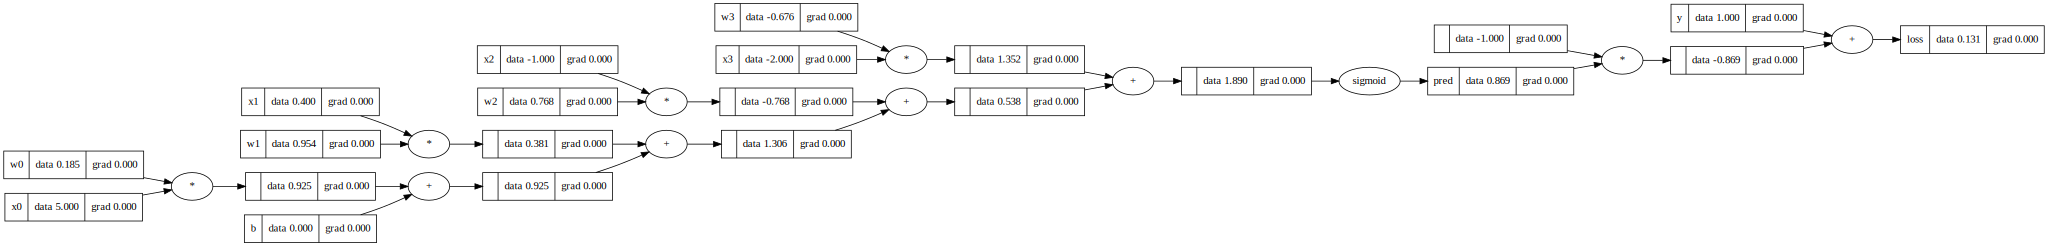

In [26]:
draw_dot(L)

In [ ]:
while True:
  L.zero_grad()

  # backward pass
  L.backward()

  # gradient descent
  L.optimize()

  # forward pass
  pred = n(X)
  L = y - pred

  print(f'Loss {L.data:.4f}')

  if L.data < 0.01:
    print(f'\nInputs: {X}')
    print(f'Parameters: {n.W} {n.b}')
    print(f'Prediction Probability: {pred.data}')
    break

Loss 0.1273
Loss 0.1235
Loss 0.1199
Loss 0.1165
Loss 0.1132
Loss 0.1101
Loss 0.1072
Loss 0.1043
Loss 0.1016
Loss 0.0991
Loss 0.0966
Loss 0.0943
Loss 0.0920
Loss 0.0899
Loss 0.0878
Loss 0.0858
Loss 0.0839
Loss 0.0821
Loss 0.0804
Loss 0.0787
Loss 0.0770
Loss 0.0755
Loss 0.0740
Loss 0.0725
Loss 0.0711
Loss 0.0698
Loss 0.0685
Loss 0.0672
Loss 0.0660
Loss 0.0648
Loss 0.0637
Loss 0.0626
Loss 0.0615
Loss 0.0605
Loss 0.0595
Loss 0.0585
Loss 0.0576
Loss 0.0567
Loss 0.0558
Loss 0.0549
Loss 0.0541
Loss 0.0533
Loss 0.0525
Loss 0.0517
Loss 0.0510
Loss 0.0503
Loss 0.0496
Loss 0.0489
Loss 0.0482
Loss 0.0476
Loss 0.0469
Loss 0.0463
Loss 0.0457
Loss 0.0451
Loss 0.0445
Loss 0.0440
Loss 0.0434
Loss 0.0429
Loss 0.0424
Loss 0.0419
Loss 0.0414
Loss 0.0409
Loss 0.0404
Loss 0.0399
Loss 0.0395
Loss 0.0390
Loss 0.0386
Loss 0.0382
Loss 0.0378
Loss 0.0373
Loss 0.0369
Loss 0.0366
Loss 0.0362
Loss 0.0358
Loss 0.0354
Loss 0.0351
Loss 0.0347
Loss 0.0344
Loss 0.0340
Loss 0.0337
Loss 0.0334
Loss 0.0330
Loss 0.0327
Loss

## Artificial Neural Network

Glosser.ca - Own work, Derivative of [Artificial neural network.svg](https://commons.wikimedia.org/wiki/File:Artificial_neural_network.svg) ([CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0) | [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg))

![Neural Network](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

We managed to train our single neuron to learn a function for our input values. In reality, however, data is much more complex and we need to learn more complication functions. How to achieve that? By chaining many neurons together, similar to biological neuron. Each neuron will basically learn some portion of the overall function.

What we see above is an illustration of an artificial neural network. In the _input layer_ we have three neurons, each separately accepting N-dimensional input values. The output values of each neuron are then fully connected, as inputs to the _hidden layer_ with four neurons (note that there can be more than one hidden layer). And finally, the output of hidden layer neurons are passed as inputs to the _output layer_, which may, for example, predict probability scores for two classes.

We will now try to implement a fully connected feedforward neural network, which is often referred to as [Multi-Layer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

In [28]:
class Layer:
  def __init__(self, N, count):
    self.neurons = [Neuron(N) for _ in range(count)]

  def __call__(self, X):
    outs = [n(X) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # flattening dimension if a single element

The code above creates a list of `count` number of neurons, each accepting `N` dimensional input. Let's build our layers shown in the illustration above and connect them. Note that the input dimension of the next layer is the amount of neurons in the previous layer.

In [29]:
# input data and its dimension
X = [Value(x, label=f'x{i}') for i, x in enumerate([1, 4, -3, -2, 3])]
N = len(X)

In [30]:
# creating layers
in_layer = Layer(N, 3)
hid_layer = Layer(3, 4)
out_layer = Layer(4, 2)

In [31]:
# output of each layer is input to the next
X_hidden = in_layer(X)
X_output = hid_layer(X_hidden)
out = out_layer(X_output)

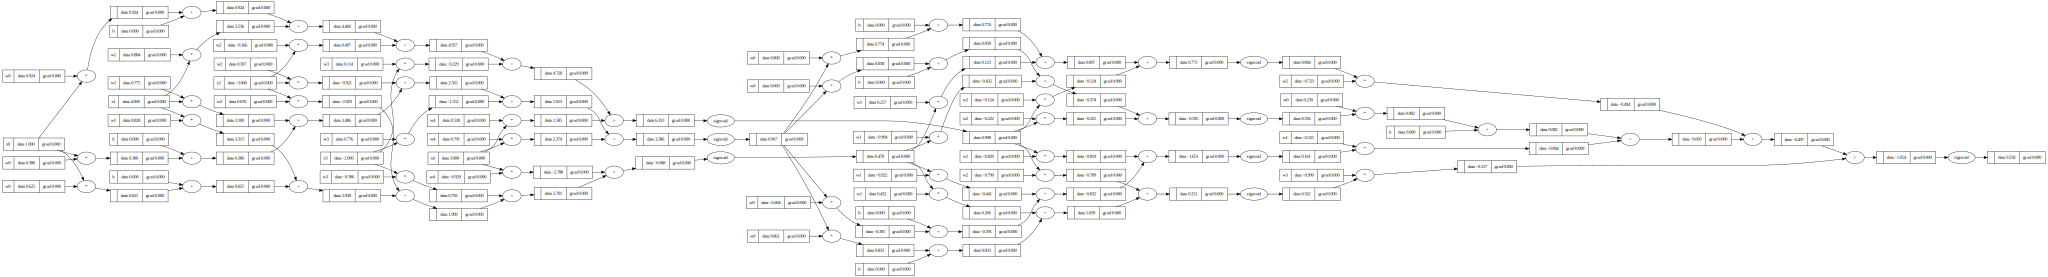

In [32]:
# let's plot either one of the outputs
draw_dot(out[0])

We will further abstract away the neuron and layer creation inside the `MLP` class. We will then reimplement the exact same network.

In [33]:
class MLP:
  def __init__(self, N, counts):
    dims = [N] + counts # concatenates dimensions
    self.layers = [Layer(dims[i], dims[i+1]) for i in range(len(dims)-1)]

  def __call__(self, X):
    out = X
    for layer in self.layers:
      out = layer(out)
    return out

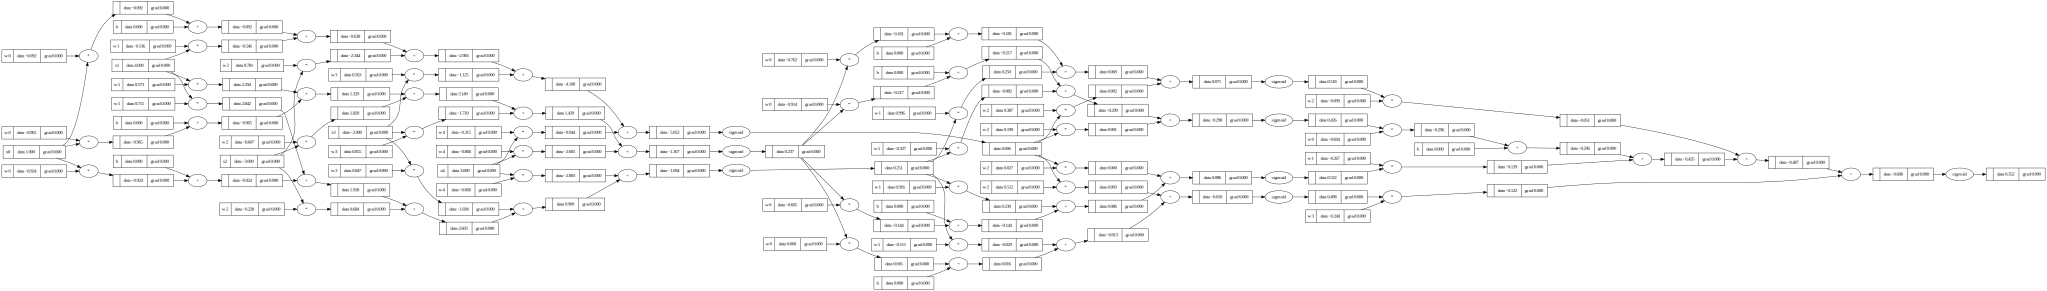

In [34]:
nn = MLP(N, [3, 4, 2])
out = nn(X)
draw_dot(out[0]) # out[1] will return the second output

## Iris Dataset

It is time to judge our network by applying it to the real dataset. Even though applying neural networks to Fisher's [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) is a little overkill (as the dataset is simple), it will be a nice demonstration of our MLP's capacity.

Iris dataset has 4-dimensional input samples with three possible output classes. We should be able to predict the class of the Iris flower based on the width and height values of its two elements. We will load our dataset and split it into train and test sets.

In [35]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X = iris.data  # 50x3 4-dimensional samples
y = iris.target # 3 classes (0, 1, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'Train data shape: {X_train.shape}, {y_train.shape}')
print(f'Test data shape: {X_test.shape}, {y_test.shape}')
print(f'Input Samples:\n {X_train[:5]}')
print(f'Labels:\n {y_train[:5]}')

Train data shape: (120, 4), (120,)
Test data shape: (30, 4), (30,)
Input Samples:
 [[4.4 2.9 1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [6.5 3.  5.5 1.8]
 [6.4 3.1 5.5 1.8]
 [6.3 2.5 5.  1.9]]
Labels:
 [0 0 2 2 2]


 We should then convert each element to be a `Value` object. But before that, let's try out two ready [scikit-learn](https://scikit-learn.org/) classifiers, `LogisticRegression` and `MLPClassifier`, the latter of which can be seen as the extension of the former, which we will implement in its simplistic form. As we have already discussed, `LogisticRegression` is basically our `Neuron` class which uses `sigmoid` (logistic) function as its activation. And in fact, Logistic Regression will simply be our MLP with the layer size for just a single neuron. Thanks to `numpy` [vectorization](https://stackoverflow.com/questions/75667527/numpy-vectorization-and-algorithmic-complexity) and other optimizations, the `sklearn` implementations will be extremely quick.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

model = MLPClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"MLP Classifier Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 1.00
MLP Classifier Accuracy: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


When converting labels to `Value` objects, we can technically scale them down to be between `0` and `1` (by multiplying them to `0.5`). Then we can apply the simple [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error). Because there are only three labels and the dataset is small, it will work, yet it will penalize ordinal labels unnecessarily. For example, our loss should give the same penalty if we predict `0` instead of `1` or `2`  (it is either one type of flower or another). MSE, however, will give more penalty when predicting `0` instead of `2` and less penalty when predicting `0` instead of `1` because of the imaginary distances between numbers, which do not exist among the real labels.

In [37]:
# converting numpy float arrays into Value lists
# scaling labels to be between 0 and 1 to simplify our code
# again, it is not a right way to treat the labels
X_train = [[Value(x) for x in X] for X in X_train]
X_test = [[Value(x) for x in X] for X in X_test]
y_train = [Value(y) * Value(0.5) for y in y_train]
y_test = [Value(y) * Value(0.5) for y in y_test]

# Training Custom MLP Classifier

We will now create a class for our model, in the style of `scikit-learn` models, more specifically [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

As noted above, what we do is simple and will work in this case, but is **not right**. Ideally, we should initially [one hot](https://en.wikipedia.org/wiki/One-hot) encode the ground truth labels to describe them with only zeros and ones. Our final layer for [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification), instead of `sigmoid` activation, should output `logits` (unprocessed predictions) passing through `softmax` function. The loss in this case should be [Cross Entropy](https://en.wikipedia.org/wiki/Cross-entropy) instead of MSE.

**Exercise (Advanced):** Write code for the correct implementation noted above. See Josh Starmer's (StatQuest) videos which explain its theory, including the [Iris dataset, argmax and softmax functions](https://www.youtube.com/watch?v=KpKog-L9veg&t=261s), as well as [Cross Entropy](https://www.youtube.com/watch?v=6ArSys5qHAU).

In [ ]:
class Classifier:
  def __init__(self, layer_sizes=[2, 3, 1]):
    self.layer_sizes = layer_sizes
    self.nn = None
    self.L = None
    self.iterations = 0

  def forward(self, Xs):
    out = [self.nn(X) for X in Xs]
    return out

  def predict(self, X_test):
    return self.forward(X_test)

  def train(self, X_train, y_train, learning_rate=0.01):
    preds = self.forward(X_train)
    self.L = self.mean_squared_error(y_train, preds)
    self.L.zero_grad()
    self.L.backward()
    self.L.optimize(learning_rate=learning_rate)
    print(f'Loss: {self.L.data:.4f}')

  def fit(self, X_train, y_train, learning_rate=0.01, num_epochs=50):
    if not self.nn: # in order to not restart training if nn exists
      self.nn = MLP(len(X_train), self.layer_sizes)
    for i in range(num_epochs):
      print(f'Training epoch {self.iterations + i + 1}')
      self.train(X_train, y_train, learning_rate)
    self.iterations += i + 1

  def mean_squared_error(self, y_train, preds):
    return sum([(y-y_hat)*(y-y_hat) for y, y_hat in zip(y_train, preds)], Value(0))

  def score(self, y_test, preds):
    return self.mean_squared_error(y_test, preds).data / len(y_test)

  def accuracy_score(self, y_test, preds):
    # due to incorrect handling of the labels
    # we need to scale y_test and preds values back
    y_test = [y * Value(2) for y in y_test]
    preds = [y_hat * Value(2) for y_hat in preds]
    correct = sum(1 for y, y_hat in zip(y_test, preds) if round(y_hat.data) == y.data)
    total = len(y_test)
    return (correct/total)

Our naive classifer is ready and we can now train our model and note the accuracy. However, unlike the optimized classifiers of the `sklearn` library, it will be much slower and inefficient. Try out experiments with different layer sizes and learning rates, and notice how it affects the training process and loss. As we have mentioned before, we can implement Logistic Regression by simply passing `layer_sizes=[1]` to our MLP classifier.

In [45]:
model = Classifier([1])
# model = Classifier([4, 1])

In [48]:
model.fit(X_train, y_train, learning_rate=0.002, num_epochs=30)

Training epoch 61
Loss: 1.3948
Training epoch 62
Loss: 1.3938
Training epoch 63
Loss: 1.3929
Training epoch 64
Loss: 1.3920
Training epoch 65
Loss: 1.3911
Training epoch 66
Loss: 1.3901
Training epoch 67
Loss: 1.3892
Training epoch 68
Loss: 1.3883
Training epoch 69
Loss: 1.3874
Training epoch 70
Loss: 1.3865
Training epoch 71
Loss: 1.3856
Training epoch 72
Loss: 1.3847
Training epoch 73
Loss: 1.3838
Training epoch 74
Loss: 1.3830
Training epoch 75
Loss: 1.3821
Training epoch 76
Loss: 1.3812
Training epoch 77
Loss: 1.3803
Training epoch 78
Loss: 1.3795
Training epoch 79
Loss: 1.3786
Training epoch 80
Loss: 1.3777
Training epoch 81
Loss: 1.3769
Training epoch 82
Loss: 1.3760
Training epoch 83
Loss: 1.3752
Training epoch 84
Loss: 1.3743
Training epoch 85
Loss: 1.3735
Training epoch 86
Loss: 1.3726
Training epoch 87
Loss: 1.3718
Training epoch 88
Loss: 1.3710
Training epoch 89
Loss: 1.3701
Training epoch 90
Loss: 1.3693


In [49]:
preds = model.predict(X_train)
print(f'Custom MLP classifier accuracy on train Data: {model.accuracy_score(y_train, preds):.2f}')

Custom MLP classifier accuracy on train Data: 0.97


In [50]:
preds = model.predict(X_test)
print(f'Custom MLP classifier accuracy on test Data: {model.accuracy_score(y_test, preds):.2f}')

Custom MLP classifier accuracy on test Data: 0.97


In [51]:
for i in range(len(y_test)):
  print(y_test[i].data * 2, preds[i].data * 2)

2.0 1.7378279677947062
1.0 1.3786491598121862
2.0 1.7797233124612888
2.0 1.5546211532302696
1.0 0.7808593322180695
1.0 1.1323777346177633
0.0 0.03179964376674919
2.0 1.6900839613983492
2.0 1.818651271834627
2.0 1.5712929781499119
2.0 1.9175600703929185
2.0 1.8478802623012778
2.0 1.8502101169387906
0.0 0.024109593550568645
1.0 1.6944624014543954
1.0 1.1691956406120396
2.0 1.6617236866912894
2.0 1.7796042897673732
1.0 1.186491156964572
2.0 1.7267232886353379
1.0 1.197352283588582
0.0 0.01104177713999268
2.0 1.860650974045892
0.0 0.029735232803150373
1.0 1.021880542808286
1.0 0.7892688298891827
0.0 0.026875629893556307
1.0 1.219772374852777
0.0 0.015342452967957023
2.0 1.5336924121298994
